First let's import the data and necessary libraries for this model

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn
import statistics
import math
import random
pj_data = pd.read_csv("/content/PJxgb.csv")

We need to make sure that the data imported correctly

In [2]:
pj_data

,Unnamed: 0,make_time,inhopper,stuffed_crust,is_plan_ahead,Pizzas,Sides,Beverages,Sandwiches,Afternoon,Lunch,Evening,Dinner,Late_night
0,1,14.967,1,0,0,2,0,0,0,0,0,0,1,0
1,2,14.967,2,0,0,2,0,0,0,0,0,0,1,0
2,3,14.967,3,0,0,2,0,0,0,0,0,0,1,0
3,4,14.017,1,1,0,2,0,0,0,0,0,0,1,0
4,5,14.017,2,0,0,2,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27581,27582,11.450,1,0,0,1,0,0,0,0,0,0,1,0
27582,27583,11.450,2,0,0,1,0,0,0,0,0,0,1,0
27583,27584,7.150,1,0,0,1,0,0,0,0,0,0,1,0
27584,27585,10.283,1,0,0,1,0,0,0,0,0,0,1,0


It looks like there was an extra column added to the data during the importing process. We can get rid of that easily using the pop function.

In [3]:
pj_data.pop("Unnamed: 0")

0            1
1            2
2            3
3            4
4            5
         ...  
27581    27582
27582    27583
27583    27584
27584    27585
27585    27586
Name: Unnamed: 0, Length: 27586, dtype: int64

Now theres no more extra column. To maximze the capabilities of this model I'm going to need to run a gridsearch. The gridsearch that I am running is a fine, randomized gridsearch. It takes randomly selected values for each of the selected hyperparameters and runs the XGBoost Model using said parameters. This process is repeated 99 more times and the hyperparameter set with the lowest "Root Mean Squared Error" will be the optimal hyperparameter set.  

In [4]:
grid = pd.DataFrame()

for i in range(100):
    learn_rate = random.uniform(.0075, .03)
    gamma = random.uniform(0,6)
    m_depth = random.randint(3,5)
    mcw = random.randint(6,10)
    int(mcw)
    subs = random.uniform(.1, .5)
    colsample = random.uniform(.6,1)
    a_row = pd.Series([learn_rate, gamma, m_depth, mcw, subs, colsample])
    row_df = pd.DataFrame([a_row])
    grid = pd.concat([row_df, grid], ignore_index=True)

In [5]:
grid.columns = ["Eta", "gamma", "max_tree_depth", "min_child_weight", "subsample", "colsample_bytree"]

grid = grid.T

Now we convert the data format from pandas dataframe to xgb format. The xgb model will only take inputs in that format.

In [6]:
train = pj_data
train_label = train.pop("make_time")

In [7]:
pj_data = pd.read_csv("/content/PJxgb.csv")
pj_data.pop("Unnamed: 0")
label = pj_data.pop("make_time")

In [8]:
full = xgb.DMatrix(pj_data, label=label)
train_xgb = xgb.DMatrix(train, label=train_label)
pj_data = pd.read_csv("/content/PJxgb.csv")

In [9]:
pj_data.pop("Unnamed: 0")
pj_data

,make_time,inhopper,stuffed_crust,is_plan_ahead,Pizzas,Sides,Beverages,Sandwiches,Afternoon,Lunch,Evening,Dinner,Late_night
0,14.967,1,0,0,2,0,0,0,0,0,0,1,0
1,14.967,2,0,0,2,0,0,0,0,0,0,1,0
2,14.967,3,0,0,2,0,0,0,0,0,0,1,0
3,14.017,1,1,0,2,0,0,0,0,0,0,1,0
4,14.017,2,0,0,2,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27581,11.450,1,0,0,1,0,0,0,0,0,0,1,0
27582,11.450,2,0,0,1,0,0,0,0,0,0,1,0
27583,7.150,1,0,0,1,0,0,0,0,0,0,1,0
27584,10.283,1,0,0,1,0,0,0,0,0,0,1,0


This is the gridsearch

THIS TAKES OVER 4 HOURS TO RUN. UPLOAD THE GRIDSEARCH CSV INSTEAD.

In [ ]:
gscv = pd.DataFrame()

i = 0
for row in grid:
    eta = grid[row]["Eta"]
    gamma = grid[row]["gamma"]
    mtd = grid[row]["max_tree_depth"]
    mcw = grid[row]["min_child_weight"]
    subsample = grid[row]["subsample"]
    colsample = grid[row]["colsample_bytree"]

    mtd = int(mtd)
    mcw = int(mcw)

    params = {
    'objective':"count:poisson",
    'eta':eta,
    'gamma':gamma,
    'max_depth':mtd,
    'min_child_weight':mcw,
    'subsample':subsample,
    'colsample_bytree':colsample,
    'eval_metric':"rmse",
    'base_score':statistics.mean(pj_data['make_time'])}

    XGboost_CV = xgb.cv(params, train_xgb,  num_boost_round=2000, nfold=10, early_stopping_rounds=50)
    logloss = XGboost_CV['test-rmse-mean'].min()
    nrounds = XGboost_CV['test-rmse-mean'].argmin()
    full_model = xgb.train(params, full, nrounds)
    xgb_predict = full_model.predict(full)
    predict = pd.DataFrame(xgb_predict)

    b_row = pd.Series([eta, gamma, mtd, mcw, subsample, colsample, logloss])
    row_b = pd.DataFrame([b_row])
    gscv = pd.concat([row_b, gscv], ignore_index=True)
    print("iteration: ", i )
    i = i+1

In [12]:
gscv.columns = ["Eta", "gamma", "max_tree_depth", "min_child_weight", "subsample", "colsample_bytree", "logloss"]
gs = gscv

Here is the gridsearch csv upload. 

In [ ]:
gs = pd.read_csv("")

Text(0.5, -0.2, 'Coarse Randomized Gridsearch Results')

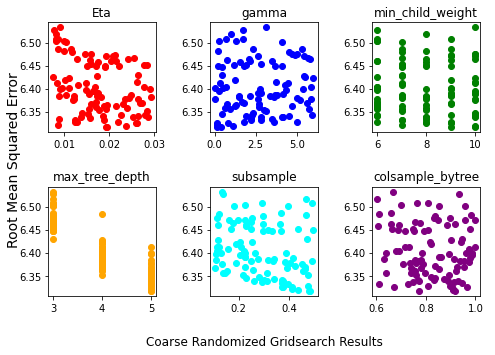

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure()

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


data_1=np.array(gs["Eta"])
data_2=np.array(gs["gamma"])
data_3=np.array(gs["min_child_weight"])
data_4=np.array(gs["max_tree_depth"])
data_5=np.array(gs["subsample"])
data_6=np.array(gs["colsample_bytree"])

logloss=np.array(gs["logloss"])

ax1.scatter(data_1,logloss, color="red")
ax2.scatter(data_2,logloss, color="blue")
ax3.scatter(data_3,logloss, color="green")
ax4.scatter(data_4,logloss, color="orange")
ax5.scatter(data_5,logloss, color="cyan")
ax6.scatter(data_6,logloss, color="purple")

ax1.set_title('Eta')

ax2.set_title('gamma')

ax3.set_title('min_child_weight')

ax4.set_title('max_tree_depth')

ax5.set_title('subsample')

ax6.set_title('colsample_bytree')

plt.subplots_adjust(top=1, bottom=0.05, left=0, right=1, hspace=0.5,
                    wspace=0.5)
fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel("Root Mean Squared Error", fontsize=14, x=-3)

plt.title('Coarse Randomized Gridsearch Results', y=-0.2)


<Figure size 432x288 with 0 Axes>

In [14]:
i = gs["logloss"].argmin()
Eta = gs.at[i,'Eta']
gamma = gs.at[i,'gamma']
min_child_weight = gs.at[i,'min_child_weight']
max_tree_depth = gs.at[i,'max_tree_depth']
subsample = gs.at[i,'subsample']
colsample_bytree = gs.at[i,'colsample_bytree']

max_tree_depth = int(max_tree_depth)
min_child_weight = int(min_child_weight)

In [15]:
    params = {
    'objective':"count:poisson",
    'eta':Eta,
    'gamma':gamma,
    'max_depth':max_tree_depth,
    'min_child_weight':min_child_weight,
    'subsample':subsample,
    'colsample_bytree':colsample_bytree,
    'eval_metric':"rmse",
    'base_score':statistics.mean(pj_data['make_time'])}

In [16]:
params

{'base_score': 12.75761531211484,
 'colsample_bytree': 0.7721225102867237,
 'eta': 0.01937676787990775,
 'eval_metric': 'rmse',
 'gamma': 0.41603980974113175,
 'max_depth': 5,
 'min_child_weight': 10,
 'objective': 'count:poisson',
 'subsample': 0.4765270569765633}

# XGBoost Parameters
### Eta 
The learning rate of the model. Allows for step size shrinkage. Lower eta values leads to higher number of boosting rounds\
### Gamma
Minimum loss reduction value. Gamma can cause shallower trees as the model will only add leaf nodes if the gain is equal to or higher than the gamma value.\
### Max Tree Depth
Maximum depth of each tree. Higher maximum tree depth will lead to a higher likelihood of overfitting, especially with a lower number of features. \
### Minimum Child Weight
The minimum value of the sum of the hessians in order to add another leaf node.\
\begin{equation*}
hessian = \sum{\frac{1}{1 + e^{-\hat{y}}}(1 - \frac{1}{1 + e^{-\hat{y}}})}
\end{equation*} for each data point.\
Lower min_child_weight may lead to overfitting, while higher min_child_weights will lead to underfitting

### Subsample
The ratio of the dataset thats used as a sample for creating each tree. The lower the subsample, the lower the likelihood of overfitting.
### Colsample by Tree
The ratio of columns selected as a sample for each new tree. 

In [17]:
nrounds = 30000
XGboost_CV = xgb.cv(params, train_xgb, num_boost_round=nrounds, nfold=10, early_stopping_rounds=50)

In [18]:
nrounds = XGboost_CV['test-rmse-mean'].argmin()
nrounds

842

In [19]:
full_model = xgb.train(params, full, nrounds)

In [20]:
xgb_predict = full_model.predict(full)

In [21]:
predict = pd.DataFrame(xgb_predict)
pj_data = pd.concat([pj_data, predict], axis=1, ignore_index=True)

In [22]:
pj_data


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.967,1,0,0,2,0,0,0,0,0,0,1,0,12.863867
1,14.967,2,0,0,2,0,0,0,0,0,0,1,0,13.038249
2,14.967,3,0,0,2,0,0,0,0,0,0,1,0,13.309861
3,14.017,1,1,0,2,0,0,0,0,0,0,1,0,13.199774
4,14.017,2,0,0,2,0,0,0,0,0,0,1,0,13.038249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27581,11.450,1,0,0,1,0,0,0,0,0,0,1,0,11.864438
27582,11.450,2,0,0,1,0,0,0,0,0,0,1,0,12.262157
27583,7.150,1,0,0,1,0,0,0,0,0,0,1,0,11.864438
27584,10.283,1,0,0,1,0,0,0,0,0,0,1,0,11.864438


In [23]:
pj_data.to_csv("pj_predict.csv")

In [24]:
gs.to_csv("gridsearch_data.csv")